In [1]:
using LinearAlgebra, FastGaussQuadrature, Plots
include("..\\Code_jail\\Misc.jl")
include("..\\Code_jail\\myquad.jl")

function OrderRoots(x)
    angles = angle.(x)
    sorted_indices = sortperm(angles)
    return x[sorted_indices]
end

ω(w) = (z) -> sum([w[i] .* z.^(i + 1) for i in 1:length(w)])
Dω(w) = (z) -> sum([(i + 1) .* w[i] .* z.^(i) for i in 1:length(w)])
DDω(w) = (z) -> sum([(i + 1) * i .* w[i] .* z.^(i-1) for i in 1:length(w)])

Φ(w, x, t, k) = begin
    ω_kt = ω(w)(k .* t.^(-1 / (length(w) + 1)))
    return 1im*k .- 1im .* ω_kt .* t ./ x 
end

DΦ(w, x, t, k) = begin
    Dω_kt = Dω(w)(k .* t.^(-1 / (length(w) + 1))) .* t.^(-1 / (length(w) + 1))
    return 1im .- 1im .* Dω_kt .* t ./ x 
end

DDΦ(w, x, t, k) = begin
    DDω_kt = DDω(w)(k .* t.^(-1 / (length(w) + 1))) .* t.^(-2 / (length(w) + 1))
    return - 1im .* DDω_kt .* t ./ x 
end

P(w, x, t, k) = begin
    result = exp(x * Φ(w, x, t, k))
    result ≈ 0.0 ? 0 : result
end

function kk0(w, x, t,rot)
    m = length(w);
    a = ones(m) .* 1im
    a[1] = x/(-(m+1)*w[m])
    for i1 = 1:(m-1)
        a[i1+1] = (i1+1)*w[i1]*t^((m-i1)/(m+1))/ ((m+1)*w[m] )
    end
    A = zeros(m,m) * 1im;
    for i1=1:m-1
        A[i1+1,i1] = 1.0;
    end
    A[:,m] = -1. .* a
    E = A |> eigen
    result = (E.values * rot^(-1)) |> filter(k -> imag(k) >= -1e-15)
    return OrderRoots(result * rot)
end

function ArgD(w, x, t, rot)
    arg = angle.(DDΦ(w, x, t, kk0(w, x, t, rot)))
end

function mod_offset(x, m, offset)
    return offset .+ mod.(x .- offset, m)
end

function Dirs(w, x, t,rot)
    argd = ArgD(w, x, t,rot)
    return mod_offset(-argd ./ 2 .+ π / 2, π, -π / 2)
end

function ConnectPts(R, w)
    if sign(real(w[end])) < 0
        return [exp(1im * (4 * m + 1) / (2 * (length(w) + 1)) * π) * R for m in 0:length(w)]
    else
        return [exp(1im * (4 * m - 1) / (2 * (length(w) + 1)) * π) * R for m in 0:length(w)]
    end
end

function SomeConnectPts(R, w)
    if sign(real(w[end])) < 0
        return [exp(1im * (4 * m + 1) / (2 * (length(w) + 1)) * π) * R for m in 0:floor(length(w)/2.)]
    else
        return [exp(1im * (4 * m - 1) / (2 * (length(w) + 1)) * π) * R for m in 0:floor(length(w)/2.) + 1]
    end
end


function Min2(X, Y)
    out = []
    for x in X
        temp = abs.(Y .- x)
        p1 = argmin(temp)
        temp[p1] = Inf
        p2 = argmin(temp)
        push!(out, (Y[p1], Y[p2]))
    end
    return out
end

function GlobalR(w, x, t)
    return (30 + abs(x)^2 + 1000 / length(w))^(1 / (length(w) + 1))
end

function Rads(w, xx, tt, rot)

    K0 = kk0(w, xx, tt, rot)

    close = Min2(K0, ConnectPts(GlobalR(w, xx, tt), w))

    args = Dirs(w, xx, tt, rot) 

    maxrads = []
    if length(w) > 1
        for i in 1:length(close)
            θ = angle.(close[i][1])
            ϕ = θ - args[i]
            γ = K0[i] * exp(-1im * args[i])
            s = imag(γ) / imag(exp(1im * ϕ))
            r1 = s * exp(1im * ϕ) - γ
            θ = angle.(close[i][2])
            ϕ = θ - args[i]
            γ = K0[i] * exp(-1im * args[i])
            s = imag(γ) / imag(exp(1im * ϕ))
            r2 = s * exp(1im * ϕ) - γ
            push!(maxrads, minimum(abs.([r1, r2])))
        end
    else
        maxrads = [Inf]
    end
    scalerads = [10 / sqrt(abs(DDΦ(w, xx, tt, k)) * abs(xx / 2)) for k in K0]
    
    return K0, args, close, [minimum(r) for r in zip(maxrads, scalerads)]
end

function SDPaths(w, xx, tt, rot)

    K0, args, close, rads = Rads(w, xx, tt, rot)

    paths = [K0[i] .+ [rads[i] * exp(1im * (args[i] + π)) 0; 0 rads[i] * exp(1im * args[i])] for i in 1:length(K0)]

    return K0, close, paths
end

function sortreal(x)
    return sort(x, by=real)
end

function SmallXPath(w, x, t)
    p1 = sortreal(SomeConnectPts(0.5, w))
    p2 = sortreal(SomeConnectPts(GlobalR(w, x, t), w))
    if length(w) == 1
        p1 .+= 0.5 .+ 0im
    end
    s = [];
    c = [];
    for i in 1:length(p1) - 1
        push!(s, [p2[i], p1[i]], [p1[i], p1[i+1]], [p1[i+1], p2[i+1]])
        push!(c, ["inf", "CP_ent"], ["CP_ent", "CP_ext"], ["CP_ext", "inf"])
    end
    return s, c
end

function SortAbsIm(x)
    return sort(x, by = x -> abs(imag(x)))
end

function LEOrder(x, y)
    if abs(real(x[1]) - real(y[1])) < eps()
        return imag(x[1]) < imag(y[1])
    else
        return real(x[1]) < real(y[1])
    end
end

function SortLE(x)
    return sort(x, lt = LEOrder)
end

function flattener(path)
    flatpath = zeros(2*length(path),2) .* 1im; # Correct
    for i1 = 1:2:2*length(path)-1
        flatpath[i1,:] = path[Int(floor((i1-1.)/2.)+1.)][1,:]
        flatpath[i1+1,:] = path[Int(floor((i1-1.)/2.)+1.)][2,:]
    end 
    return flatpath
end

function dom_sectioner(path)
    a = -1; b = 1;
    distances = [abs(path[i][2]-path[i][1]) for i in 1:length(path)]; distances .*= (b-a)/sum(distances)
    t_vals = zeros(length(path)+1); t_vals[1] = a; t_vals[end] = b;
    for i1 = 1:length(path)-1
        t_vals[i1+1] = t_vals[i1]+distances[i1]
    end
    return t_vals
end

function pwlinf_maker(t,t_vals,path_nodes,meth)
    for i1 = 1:(length(t_vals)-1)
        if (t_vals[i1] <= t && t <= t_vals[i1+1])
            return (t-t_vals[i1])/(t_vals[i1+1]-t_vals[i1])*path_nodes[i1+1] + (t-t_vals[i1+1])/(t_vals[i1]-t_vals[i1+1])*path_nodes[i1]
        end
    end
    if t_vals[end] <= t
        return (t-t_vals[end-1])/(t_vals[end]-t_vals[end-1])*path_nodes[end] + (t-t_vals[end])/(t_vals[end-1]-t_vals[end])*path_nodes[end-1]
    elseif t <= t_vals[1]
        return (t-t_vals[1])/(t_vals[2]-t_vals[1])*path_nodes[2] + (t-t_vals[2])/(t_vals[1]-t_vals[2])*path_nodes[1]
    end
end

function Dpwlinf_maker(t,t_vals,path_nodes,meth)
    for i1 = 1:(length(t_vals)-1)
        if t >= t_vals[i1] && t <= t_vals[i1+1]
            return 1/(t_vals[i1+1]-t_vals[i1])*path_nodes[i1+1] + 1/(t_vals[i1]-t_vals[i1+1])*path_nodes[i1]
        end
    end
    if t_vals[end] <= t
        return 1/(t_vals[end]-t_vals[end-1])*path_nodes[end] + 1/(t_vals[end-1]-t_vals[end])*path_nodes[end-1]
    elseif t <= t_vals[1]
        return 1/(t_vals[2]-t_vals[1])*path_nodes[2] + 1/(t_vals[1]-t_vals[2])*path_nodes[1]
    end
end

function fpath_maker(path,cate)
    t_vals = dom_sectioner(path)
    meth = [];
    tt = [];
    funcs = [];
    Dfuncs = [];
    for i1 = 1:length(path)
        push!(meth, "Legendre")
        xgrid = path[i1];

        push!(funcs, t -> pwlinf_maker(t,t_vals[i1:(i1+1)],path[i1],meth[i1]))
        push!(Dfuncs, t -> Dpwlinf_maker(t,t_vals[i1:(i1+1)],path[i1],meth[i1]))
        #push!(tt, [t_vals[ind_sec_tmp[i1][1]],t_vals[ind_sec_tmp[i1][2]]])
        push!(tt, t_vals[i1:(i1+1)])
    end
    return funcs, Dfuncs, tt, meth
end

struct Deformation
    pp::Vector
    cc::Vector
    path::Vector
    Dpath::Vector
    tt::Vector
    meth::Vector
    w::Vector
end

function Deformation(path::Vector,cate::Vector,w::Vector)
    func, Dfunc, tt, meth = fpath_maker(path,cate)
    Deformation(path,cate,func, Dfunc, tt, meth,w)
end

function FullPath(w, xx, tt, rot)

    if abs(xx) < 0.1-eps() || isempty(kk0(w,xx,tt,rot))
        path, cate = SmallXPath(w, xx, tt)
        return Deformation(path, cate,w)
    end

    K0, close, paths = SDPaths(w, xx, tt, rot) # Correct

    flatpath = flattener(paths)
    connect = []
    category = []
    for i in 1:length(paths)
        ends = [paths[i][1, 1], paths[i][2, 2]]
        closer = [0., 0.] .* 1im
        if abs(ends[1] - close[i][1]) < abs(ends[2] - close[i][1])
            closer[1] = close[i][1]
        else
            closer[1] = close[i][2]
        end
        if abs(ends[2] - close[i][1]) < abs(ends[1] - close[i][1])
            closer[2] = close[i][1]
        else
            closer[2] = close[i][2]
        end
        
        push!(connect,[closer[1], ends[1]], flatpath[2*i-1,:], flatpath[2*i,:], [ends[2], closer[2]])
        push!(category, ["inf","CP_ent"],["CP_ent","CP"], ["CP","CP_ext"], ["CP_ext", "inf"])
    end
    
    return Deformation(connect,category,w)
end

function DomainPlot(D::Deformation)
    pl = plot();
    path = D.pp;
    cate = D.cc
    CP_label = "CP";
    inf_label = "inf";
    CP_ext_label = "CP_ext";
    CP_ent_label = "CP_ent";
    for i1 in 1:length(path)
        plot!([real(path[i1][1]),real(path[i1][2])],[imag(path[i1][1]),imag(path[i1][2])], arrow=true, color =:black, linewidth =2, label ="");
        for i2 in 1:2
            if cate[i1][i2] == "CP"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:green, markersize =5, label = CP_label);
                CP_label = "";
            elseif cate[i1][i2] == "inf"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:red, markersize =5, label = inf_label)
                inf_label = "";
            elseif cate[i1][i2] == "CP_ext"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:orange, markersize =5, label = CP_ext_label)
                CP_ext_label = "";
            elseif cate[i1][i2] == "CP_ent"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:blue, markersize =5, label = CP_ent_label)
                CP_ent_label = "";
            end 
        end
    end

    ww = D.w;
    n = length(ww) + 1;

    xr = xlims(pl);
    yr = ylims(pl);

    # Generate a grid of complex numbers
    xplt = LinRange(xr[1], xr[2], 500)
    yplt = LinRange(yr[1], yr[2], 500)
    z = [a + 1im*b for a in yplt, b in xplt]
    
    # Create a mask for points where real((x + yi)^2) < 0
    mask = [real(1im*ww[end]*(zi)^n) >= 0 for zi in z]
    mmask = [ NaN for zi in z]
    mmask[mask] .= 0
    
    heatmap!(xplt, yplt, mmask, c=:RdBu,  alpha =0.5, cbar=false)

    plot!()|>display
end

function NumericalDomainPlot(D::Deformation)
    Legendre_label = "Legendre";
    Clen_Curt_label = "Clenshaw-Curtis";
    plot()
    for i1 = 1:length(D.path)
        t = range(D.tt[i1][1],D.tt[i1][end],100)
        if D.meth[i1] == "Clenshaw-Curtis"
            plot!(real.(D.path[i1].(t)),imag.(D.path[i1].(t)), color =:purple3, linewidth =2, label = Clen_Curt_label)


            Clen_Curt_label = "";
        elseif D.meth[i1] == "Legendre"
            plot!(real.(D.path[i1].(t)),imag.(D.path[i1].(t)), color =:magenta4, linewidth =2, label = Legendre_label)

            x, w = gausslegendre(15);
            
            trans_func = x -> (D.tt[i1][end] + D.tt[i1][1])/2 + x * (D.tt[i1][end] - D.tt[i1][1])/2 ;
            scatter!(real.(D.path[i1].(trans_func.(x))),imag.(D.path[i1].(trans_func.(x))), color =:magenta4, linewidth =2, label = "")
            Legendre_label = "";
        end
    end
    CP_label = "CP";
    inf_label = "inf";
    CP_ext_label = "CP_ext";
    CP_ent_label = "CP_ent";
    for i1 = 1:length(D.cc)
        for i2 in 1:2
            if D.cc[i1][i2] == "CP"
                scatter!([real(D.pp[i1][i2])],[imag(D.pp[i1][i2])], color =:green, markersize =5, label = CP_label);
                CP_label = "";
            elseif D.cc[i1][i2] == "inf"
                scatter!([real(D.pp[i1][i2])],[imag(D.pp[i1][i2])], color =:red, markersize =5, label = inf_label)
                inf_label = "";
            elseif D.cc[i1][i2] == "CP_ext"
                scatter!([real(D.pp[i1][i2])],[imag(D.pp[i1][i2])], color =:orange, markersize =5, label = CP_ext_label)
                CP_ext_label = "";
            elseif D.cc[i1][i2] == "CP_ent"
                scatter!([real(D.pp[i1][i2])],[imag(D.pp[i1][i2])], color =:blue, markersize =5, label = CP_ent_label)
                CP_ent_label = "";
            end 
        end
    end
    
    plot!()|>display
end



function My_Integrate(int_f,Defor,N)
    res = 0im;
    for i1 = 1:length(Defor.tt)
        s = curv(Defor.path[i1],Defor.tt[i1][1],Defor.tt[i1][end],Defor.Dpath[i1],N)
        if Defor.meth[i1] == "Legendre"
            f = stand_int(int_f,s)
            x, w = gausslegendre(N);
            res += dot(w,f.(x))
           
        elseif Defor.meth[i1] == "Clenshaw-Curtis"
            res += Clen_Curt(int_f,s)
        
        end
    end
    return res
end

function polar(z)
    return abs.(z), angle.(z)
end

function Integrand(w, xx, tt, g, rot)

    DD = FullPath(w, xx, tt, rot)
    n = length(w) + 1

    integrand = z -> g(z * tt^(-1/n)) * P(w, xx+eps(), tt, z)
    return integrand, DD
end

function Residue(f,z)
    s = curv( t -> exp.(1im*t), 0, 2*π, t -> 1im*exp.(1im*t),100)
    Clen_Curt(f,s)/(2*π*1im)
end

function SpecialFunction(w::Vector, xx::Number, tt::Number, m::Number, N::Number,gg::Function)
    tt *= -1im

    R, θ = polar(xx)
    n = length(w) + 1
    θinfl = abs(imag(exp(-1im*θ)))<1e-15 ? real(exp(-1im*θ)) : exp(-1im*θ)
    w = [w[j] * (θinfl)^(j + 1) for j in 1:length(w)];
    g = z -> gg(z .* θinfl)
    integrand, DD = Integrand(w, R * tt^(-1/n)+ eps() , tt, g,  θinfl);
    vals = My_Integrate(integrand, DD,N)

    vals -=  (real(xx) < 0 && m < 0) ? 2 * π * 1im * Residue(z -> g(z * tt^(-1/n)) * P(w, xx * tt^(-1/n), tt, z), 0) : 0
    
    (tt)^(-1/n) * vals
end

function SpecialFunction(w::Vector, xx::Number, tt::Number, m::Number, N::Number)
    g = z -> (1im*z).^m
    SpecialFunction(w, xx, tt, m, N,g)
end

SpecialFunction (generic function with 2 methods)

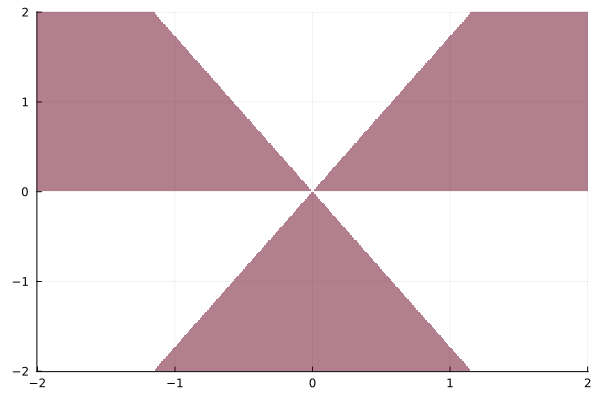

In [2]:
ww = [0,1im]
    n = length(ww) + 1;

    # Generate a grid of complex numbers
    xplt = LinRange(-2, 2, 500)
    yplt = LinRange(-2, 2, 500)
    z = [a + 1im*b for a in xplt, b in yplt]
    
    # Create a mask for points where real((x + yi)^2) < 0
    mask = [real(1im*ww[end]*(zi)^n) >= 0 for zi in z]
    mmask = [ NaN for zi in z]
    mmask[mask] .= 0
    
    heatmap(xplt, yplt, mmask, c=:RdBu,  alpha =0.5, cbar=false)

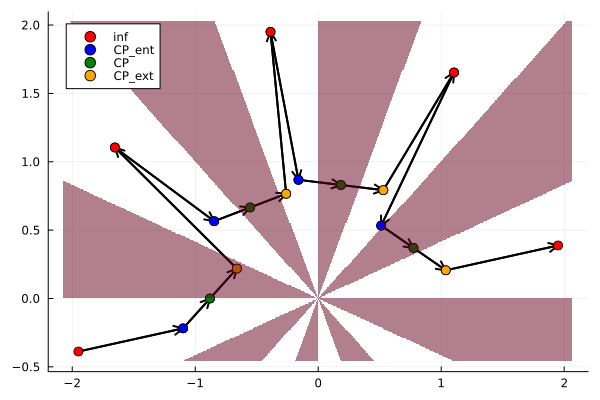

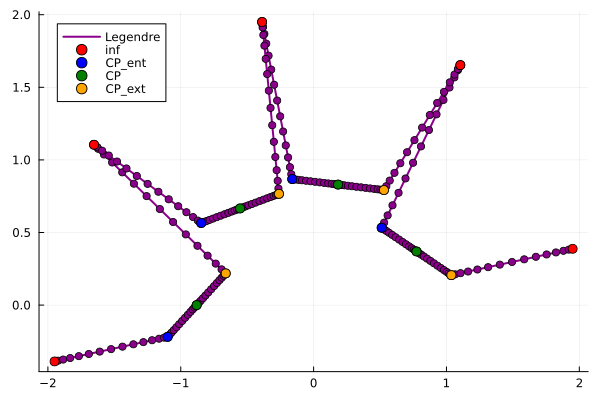

In [3]:
w = -[-2,-9,5,-1,-4,1,3];
xx = 2;
tt = 0.00001;
n = length(w)+1
DD = FullPath(w, xx * tt^(-1/n)+eps(), tt,1);
DomainPlot(DD)
NumericalDomainPlot(DD)

In [4]:
w = -[-2,-9,5,-1,-4,1,3]
N = 200;
m = 1;
x = 2;
t = 0.00001;
funt = SpecialFunction(w, x, t, m, N) |>display

2.7638639480654135 - 3.775323764254681im

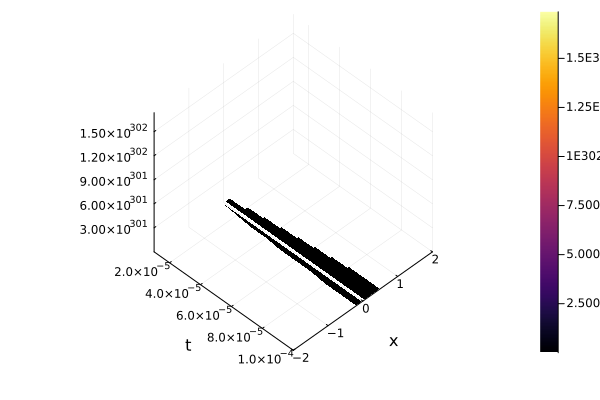

In [2]:
w = [1]
N = 200;
m = 1;

funt = (x,t) -> SpecialFunction(w, x, t, m, N);
Solu = (x,t) -> -exp(-x^2/(4*t))*sqrt(pi)*x/(2*t^(3/2));

L = 2
Nt = 10;
Nx = 101;
T = 0.0001
tt = T/(Nt):T/(Nt):T
xx = -L:2*L/(Nx-1):L

Qsol = Complex.(zeros(length(xx),length(tt)))
Rsol = Complex.(zeros(length(xx),length(tt)))
for i2 = 1:Nt
    Qsol[:,i2] = map(x->funt(x,tt[i2]),xx)
    Rsol[:,i2] = map(x->Solu(x,tt[i2]),xx)
end
surface(tt,xx, abs.((Qsol-Rsol)./Rsol) .+ 1e-16,camera = (45, 45), xlabel = "t", ylabel = "x")

In [6]:
w = [1]
N = 200;
m = 2;

funt = (x,t) -> SpecialFunction(w, x, t, m, N);
Solu = (x,t) -> -exp(-x^2/(4*t))*sqrt(pi)*(2*t-x^2)/(4*t^(5/2));

L = .02
Nt = 10;
Nx = 101;
T = 0.0001
tt = T/(Nt):T/(Nt):T
xx = -L:2*L/(Nx-1):L

Qsol = Complex.(zeros(length(xx),length(tt)))
Rsol = Complex.(zeros(length(xx),length(tt)))
for i2 = 1:Nt
    Qsol[:,i2] = map(x->funt(x,tt[i2]),xx)
    Rsol[:,i2] = map(x->Solu(x,tt[i2]),xx)
end
pl = surface(tt,xx, abs.((Qsol-Rsol)./Rsol) .+ 1e-16,camera = (45, 45), xlabel = "t", ylabel = "x")
x = xlims(pl)

(1.0e-5, 0.0001)

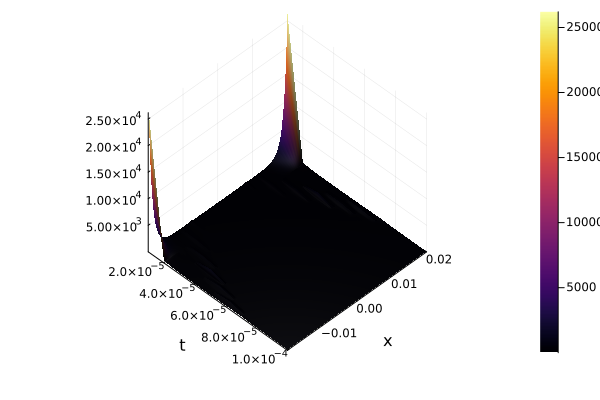

In [7]:
w = [1]
N = 200;
m = 3;

funt = (x,t) -> SpecialFunction(w, x, t, m, N);
Solu = (x,t) -> -exp(-x^2/(4*t))*sqrt(pi)*x*(-6*t+x^2)/(8*t^(7/2));

L = .02
Nt = 10;
Nx = 100;
T = 0.0001
tt = T/(Nt):T/(Nt):T
xx = -L:2*L/(Nx-1):L

Qsol = Complex.(zeros(length(xx),length(tt)))
Rsol = Complex.(zeros(length(xx),length(tt)))
for i2 = 1:Nt
    Qsol[:,i2] = map(x->funt(x,tt[i2]),xx)
    Rsol[:,i2] = map(x->Solu(x,tt[i2]),xx)
end
surface(tt,xx, abs.((Qsol-Rsol)./Rsol) .+ 1e-16,camera = (45, 45), xlabel = "t", ylabel = "x")

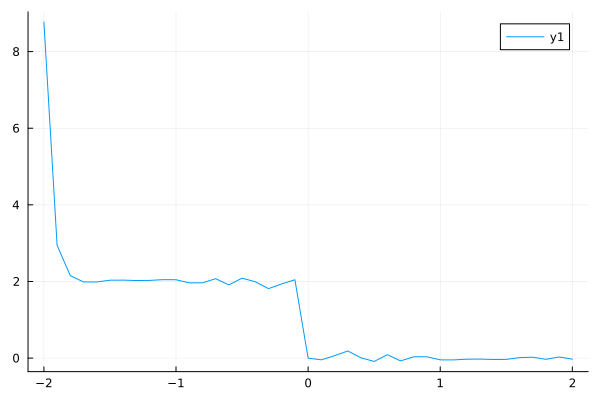

In [8]:
using SpecialFunctions
include("..\\Code_jail\\Cheb.jl")

x = -2:.1:2
w = [1]
N = 200;
m = -1;
t = 0.01
funt = x -> SpecialFunction(w, x, t, m, N);
plot(x,real.(funt.(x))/(2*pi)+erfc.(x ./ (2*sqrt(t)))/2)